<h1 style="color: blue;">3. GPU Memory</h1>

<h2 style="color: green;">메모리 구조(On-chip)</h2>

GPU 칩 안에 있는 메모리로, 레지스터 메모리 / 로컬 메모리라고 부릅니다.레지스터는 GPU 커널 안에 선언되는 변수로, GPU 칩안에 있기 때문에 접근 속도가 빠릅니다. 
레지스터 변수는 코어에 할당된 스레드가 분배해서 사용하는데, 커널 안에서 사용해야 할 변수가 많아지면 로컬 메모리에 레지스터 변수를 할당할 수 있습니다.

온칩은 속도가 빠른 대신에 비용 등의 이유로 인해 메모리 사이즈가 비교적 작습니다. 

<h2 style="color: green;">메모리 구조(Off-chip)</h2>

그래픽 카드에 장착한 DRAM으로, GPU 기본 메모리는 GDDR5 메모리를 사용합니다. CUDA에서는 이 off칩을 글로벌 메모리 / 디바이스 메모리라고 합니다. 계산에 필요한 입력 데이터는 GPU가 아닌 CPU 메모리 영역에 있기 때문에 PCI-e 인터페이스를 통해서 GPU로 메모리를 전송합니다.

오프칩은 속도가 느린 대신에 메모리 사이즈가 큽니다.

<h2 style="color: green;">메모리 구조(Shared Memory)</h2>

GPU shared memory는 여러 개의 스레드가 공유해서 사용할 수 있는 메모리 영역입니다. 
이 메모리는 각 스레드가 메모리를 공유하면서 처리할 때 발생하는 데이터 복사 등의 오버헤드를 줄일 수 있어서, 데이터 복사 및 전송 시간을 절약하고 성능을 향상시킬 수 있습니다.

GPU shared memory는 일반적으로 CUDA 프로그래밍에서 사용됩니다. CUDA는 NVIDIA에서 개발한 GPU 프로그래밍 언어로, CUDA를 사용하여 GPU shared memory를 사용할 수 있습니다. 

GPU shared memory는 다른 메모리와는 달리 지역성이 높아서 메모리 읽기/쓰기 속도가 빠릅니다. 그리고 GPU에서는 캐시가 존재하지 않기 때문에 데이터 전송 시간이 느리면 성능이 크게 저하됩니다. 따라서, GPU shared memory를 적극 활용하여 성능을 최적화하는 것이 중요합니다.

<h2 style="color: green;">Pinned Memory</h2>

Pinned Memory는 CPU 메모리로 GPU가 직접 액세스할 수 있는 메모리입니다. 일반적으로 CPU에서 할당하고 GPU에서 해제합니다. 이를 통해 데이터 전송 시간을 줄일 수 있습니다.

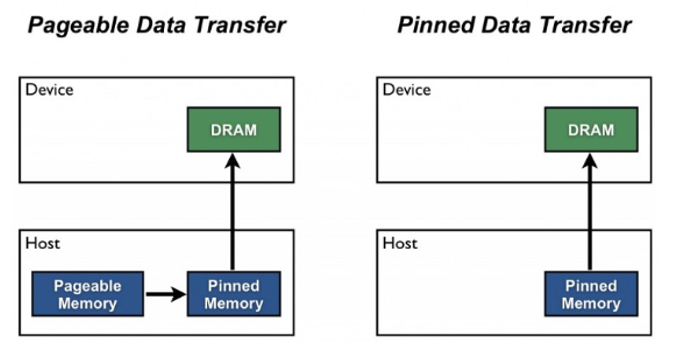

<h2 style="color: green;">Pageable Memory</h2>

Pageable Memory는 일반적으로 CPU에서 할당하고 사용하는 메모리입니다. 이는 CPU와 GPU 사이의 데이터 전송에 있어서 오버헤드를 유발할 수 있습니다. 이유는 GPU가 이 메모리에 액세스하려면 CPU가 메모리 페이지를 가져와야 하기 때문입니다.

**즉 Pinned Memory는 데이터 전송 속도를 높일 수 있지만 Pageable Memory는 그렇지 않을 수 있습니다. 일반적으로 Pinned Memory는 대용량 데이터 전송에 유용합니다.**


<h1 style="color: blue;">4. GPU util 높이기</h1>

<h2 style="color: green;">1. 데이터 파이프라인 최적화</h2>

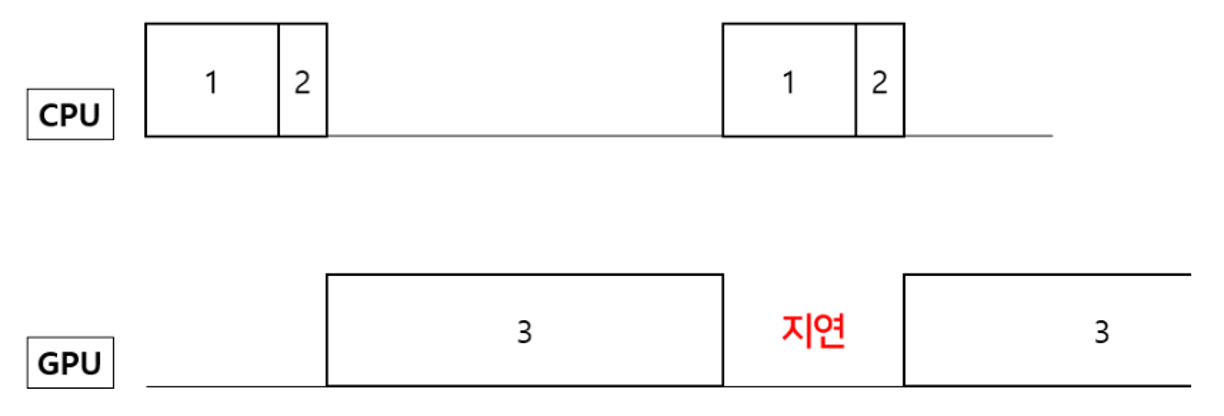
본 파이프라인대로 학습을 하게 되면 무조건 GPU Util이 99%가 되지 않는다. 그 이유는 GPU가 한 Batch 학습을 끝내고 다음 Batch 학습하기 전까지 1+2의 시간 동안 지연이 되기 때문이다. 

그래서 미리 Batch 학습이 끝나기 전에 다음 Batch를 메모리에 준비한다.

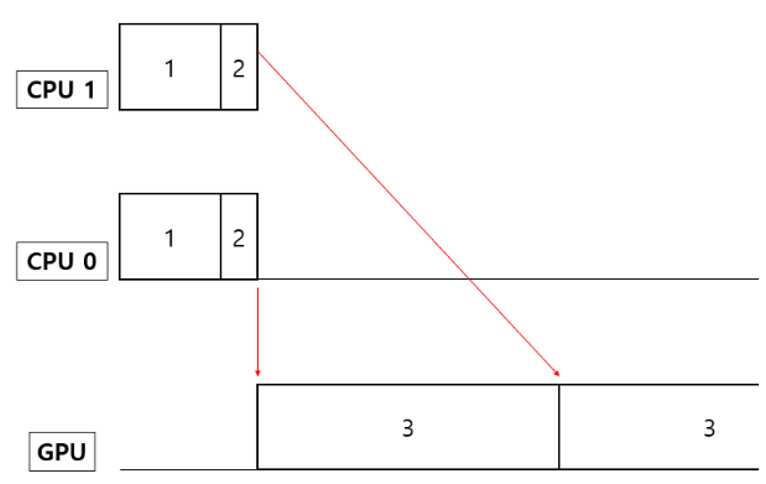
단일 프로세스이기에 생기는 1+2의 시간 지연을 없애자는 아이디어다. 즉, CPU 0이 한 Batch 준비하여 GPU에 올려 학 습하는 동안, 다른 CPU 1 (프로세스)가 다음 Batch 준비하는 것이다. 

이렇게 되면 GPU는 시간의 지연 없이 바로 다음 Batch 학습할 수 있기 때문에 지연이 일어나지 않는다. 

<h2 style="color: green;">2. 크기가 작은 Datatype 사용하기</h2>

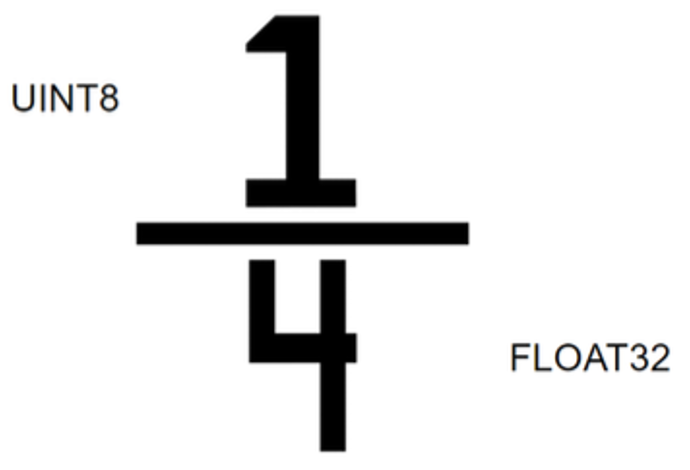
Pytorch의 경우 모델의 Parameter은 Float32 Datatype을 가지 고 있기에 Input 또한 Float32로 들어가야 한다.

하지만 Float32는 UINT8 (Unsigned Int 8로 0~255까지의 숫자를 나타 낼 수 있다)보다 4배나 그 크기가 크다. 

즉, 단적으로 숫자만 보자면 이는 데이터를 전송할 때 4배만큼의 시간이 더 걸린 다는 뜻이다. 

따라서 실제로 모델에 Input으로 넣기 전에는 크기가 작은 Datatype으로 가지고 있는 것이 전송 속도에 도 움이 된다. 

이미지의 경우 0~255 사이의 UINT8로 가지고 있다가 모델에 넣어주기 직전에 Normalize 하여 Float32로 바꿔 주는 것이 더 빠르다는 것이다.

<h2 style="color: green;">3. Chunk Hit(청크 히트)</h2>

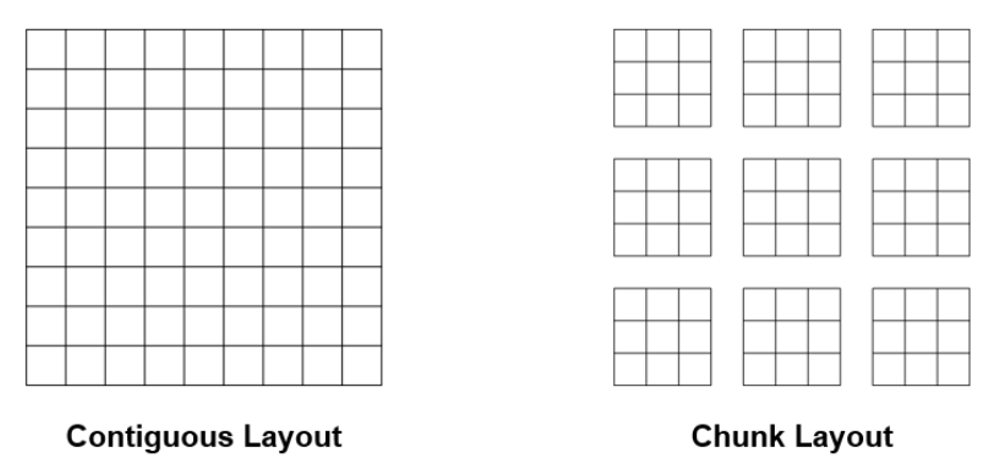
+ Dataset을 여러 개의 Chunk (블록)으로 나누어서 저장한다. 
+ 파일 안에 한 블록이 무작위로 저장된다.
+ Chunk 별로 읽고 쓸 수 있다.

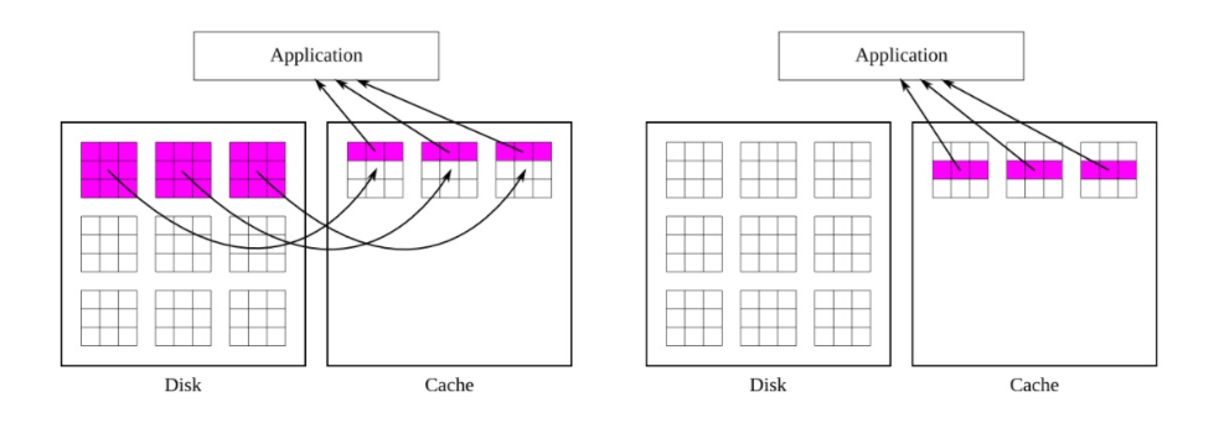
Chunk에 있는 데이터 하나를 참조하면, 해당 cHunk 전체가 메모리에 초기에 올라가고, 이후 임의의 데이터를 참조했을 때 해당 데이터가 메모리에 올라가 있는 Chunk에 있으면 메모리에서 바로 참조한다. Contiguous Layout처럼 전체 데이터를 메모리에 올리는건 불필요하고 이렇게 Chunk단위로 나누면 더욱 메모리 효율성이 좋아지고 데이터 접근이 빨라진다.

### *데이터 캐싱*
데이터를 메모리나 디스크에 캐시하여 이후에 재로드하지 않도록 할 수 있습니다. 데이터를 한 번 로드하고 나면 캐시에 저장하여 다음에 필요할 때 빠르게 액세스할 수 있습니다. 이를 통해 중복된 로드 작업을 피하고 데이터 로딩 속도를 향상시킬 수 있습니다.

### *데이터 병렬 로딩*
데이터를 병렬로 로드하여 여러 CPU 코어를 활용하여 데이터 로딩 속도를 향상시킬 수 있습니다.

### *데이터 압축*
데이터를 압축하여 디스크 용량을 절약하고 데이터 로딩 속도를 향상시킬 수 있습니다.